In [2]:
"""
encode_latent_splits.py

Use the trained Dense VAE (from train_vae_eclss.py) to encode
the preprocessed ECLSS splits into latent mean vectors μ.

Inputs (from data/eclss_preprocessed/):
    - X_train_nom_flat.npy
    - X_train_fault_flat.npy
    - X_test_nom_flat.npy
    - X_test_fault_flat.npy
    - y_train_fault_sys.npy
    - y_test_fault_sys.npy
    - y_test_nom_sys.npy

Outputs (saved to the same folder):
    - Z_train_nom.npy     (latent μ for nominal train)
    - Z_train_fault.npy   (latent μ for faulty train)
    - Z_test_nom.npy      (latent μ for nominal test)
    - Z_test_fault.npy    (latent μ for faulty test)
    - y_train_fault_sys.npy    (copied)
    - y_test_fault_sys.npy     (copied)
    - y_test_nom_sys.npy       (copied)
"""

from __future__ import annotations

import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

"""
encode_latent_splits.py

Use the trained Dense VAE (from train_vae_eclss.py) to encode
the preprocessed ECLSS splits into latent mean vectors μ.
"""

from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# ------------------------------------------------------------------
# 1) Make sure Python can see the project_root
# ------------------------------------------------------------------
sys.path.append(r"C:\Users\ahasa\project_root")

# IMPORTANT: import only DenseVAE and cfg (NOT PRE_DIR, MODEL_DIR)
from train_vae_eclss import DenseVAE, cfg

# ------------------------------------------------------------------
# 2)correct paths for this script
# ------------------------------------------------------------------
REPO_ROOT = Path(r"C:\Users\ahasa\project_root")
PRE_DIR = REPO_ROOT / "data" / "eclss_preprocessed"
MODEL_DIR = REPO_ROOT / "models"

print("PRE_DIR:", PRE_DIR)
print("MODEL_DIR:", MODEL_DIR)


class NumpyDataset(Dataset):
    """Simple Dataset wrapper around a 2D numpy array (N, D)."""

    def __init__(self, X: np.ndarray):
        self.X = torch.from_numpy(X.astype(np.float32))

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.X[idx]


def encode_to_latent(
    model: DenseVAE,
    X: np.ndarray,
    device: str,
    batch_size: int = 32,
) -> np.ndarray:
    """
    Pass a 2D array (N, D) through the encoder and return μ ∈ ℝ^{N×latent_dim}.
    """
    model.eval()
    ds = NumpyDataset(X)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    mus = []
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            _, mu, logvar = model(x)
            mus.append(mu.cpu().numpy())

    Z = np.concatenate(mus, axis=0)
    return Z


def main() -> None:
    print("===============================================")
    print(" ENCODING TRAIN/TEST SPLITS INTO LATENT SPACE ")
    print("===============================================")
    print(f"Using device: {cfg.device}")
    print(f"Preprocessed dir: {PRE_DIR}\n")

    # --------------------------------------------------------
    # 1) LOAD PREPROCESSED FLAT DATA
    # --------------------------------------------------------
    X_train_nom = np.load(PRE_DIR / "X_train_nom_flat.npy")
    X_train_fault = np.load(PRE_DIR / "X_train_fault_flat.npy")
    X_test_nom = np.load(PRE_DIR / "X_test_nom_flat.npy")
    X_test_fault = np.load(PRE_DIR / "X_test_fault_flat.npy")

    y_train_fault_sys = np.load(PRE_DIR / "y_train_fault_sys.npy")
    y_test_fault_sys = np.load(PRE_DIR / "y_test_fault_sys.npy")
    y_test_nom_sys = np.load(PRE_DIR / "y_test_nom_sys.npy")  # should be all zeros

    print("Loaded flat splits:")
    print(f"  X_train_nom:   {X_train_nom.shape}")
    print(f"  X_train_fault: {X_train_fault.shape}")
    print(f"  X_test_nom:    {X_test_nom.shape}")
    print(f"  X_test_fault:  {X_test_fault.shape}\n")

    # --------------------------------------------------------
    # 2) RECREATE MODEL AND LOAD BEST WEIGHTS
    # --------------------------------------------------------
    model = DenseVAE(
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        latent_dim=cfg.latent_dim,
    ).to(cfg.device)

    best_model_path = MODEL_DIR / "vae_dense_eclss.pth"
    model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))
    print(f"Loaded VAE weights from: {best_model_path}\n")

    # --------------------------------------------------------
    # 3) ENCODE EACH SPLIT INTO LATENT μ
    # --------------------------------------------------------
    Z_train_nom = encode_to_latent(model, X_train_nom, cfg.device, batch_size=cfg.batch_size)
    Z_train_fault = encode_to_latent(model, X_train_fault, cfg.device, batch_size=cfg.batch_size)
    Z_test_nom = encode_to_latent(model, X_test_nom, cfg.device, batch_size=cfg.batch_size)
    Z_test_fault = encode_to_latent(model, X_test_fault, cfg.device, batch_size=cfg.batch_size)

    print("Latent shapes:")
    print(f"  Z_train_nom:   {Z_train_nom.shape}")
    print(f"  Z_train_fault: {Z_train_fault.shape}")
    print(f"  Z_test_nom:    {Z_test_nom.shape}")
    print(f"  Z_test_fault:  {Z_test_fault.shape}\n")

    # --------------------------------------------------------
    # 4) SAVE LATENT FEATURES & LABELS
    # --------------------------------------------------------
    np.save(PRE_DIR / "Z_train_nom.npy", Z_train_nom)
    np.save(PRE_DIR / "Z_train_fault.npy", Z_train_fault)
    np.save(PRE_DIR / "Z_test_nom.npy", Z_test_nom)
    np.save(PRE_DIR / "Z_test_fault.npy", Z_test_fault)

    # Just re-save labels to keep everything together
    np.save(PRE_DIR / "y_train_fault_sys.npy", y_train_fault_sys)
    np.save(PRE_DIR / "y_test_fault_sys.npy", y_test_fault_sys)
    np.save(PRE_DIR / "y_test_nom_sys.npy", y_test_nom_sys)

    print("✅ Saved latent features for all splits in:")
    print(f"   {PRE_DIR.resolve()}")


if __name__ == "__main__":
    main()


PRE_DIR: C:\Users\ahasa\project_root\data\eclss_preprocessed
MODEL_DIR: C:\Users\ahasa\project_root\models
 ENCODING TRAIN/TEST SPLITS INTO LATENT SPACE 
Using device: cpu
Preprocessed dir: C:\Users\ahasa\project_root\data\eclss_preprocessed

Loaded flat splits:
  X_train_nom:   (84, 3000)
  X_train_fault: (420, 3000)
  X_test_nom:    (18, 3000)
  X_test_fault:  (180, 3000)

Loaded VAE weights from: C:\Users\ahasa\project_root\models\vae_dense_eclss.pth

Latent shapes:
  Z_train_nom:   (84, 32)
  Z_train_fault: (420, 32)
  Z_test_nom:    (18, 32)
  Z_test_fault:  (180, 32)

✅ Saved latent features for all splits in:
   C:\Users\ahasa\project_root\data\eclss_preprocessed


Combined latent vectors shape: (585, 32)
Running t-SNE...


C:\Users\ahasa\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


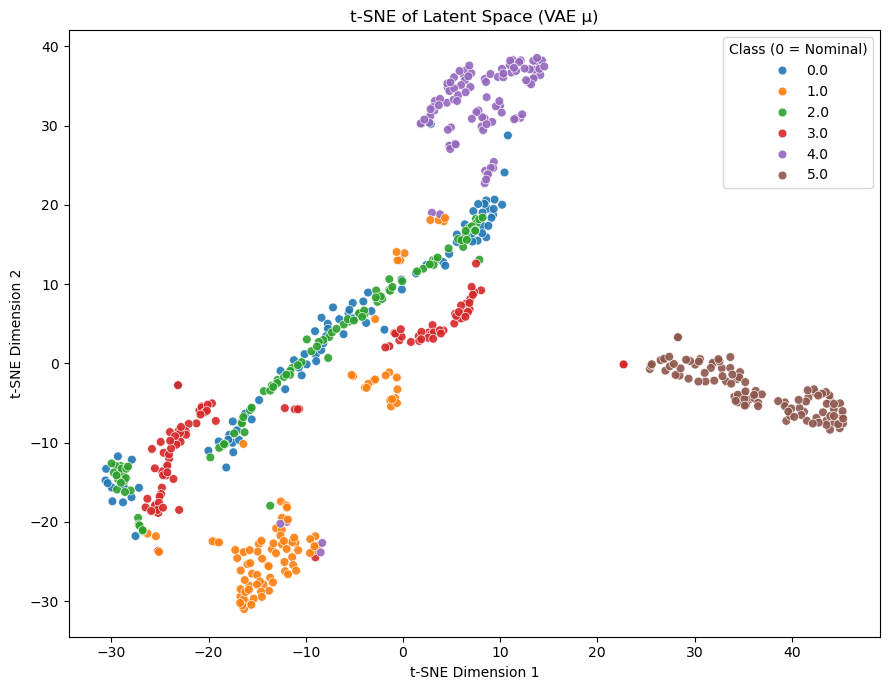

Running UMAP...


C:\Users\ahasa\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


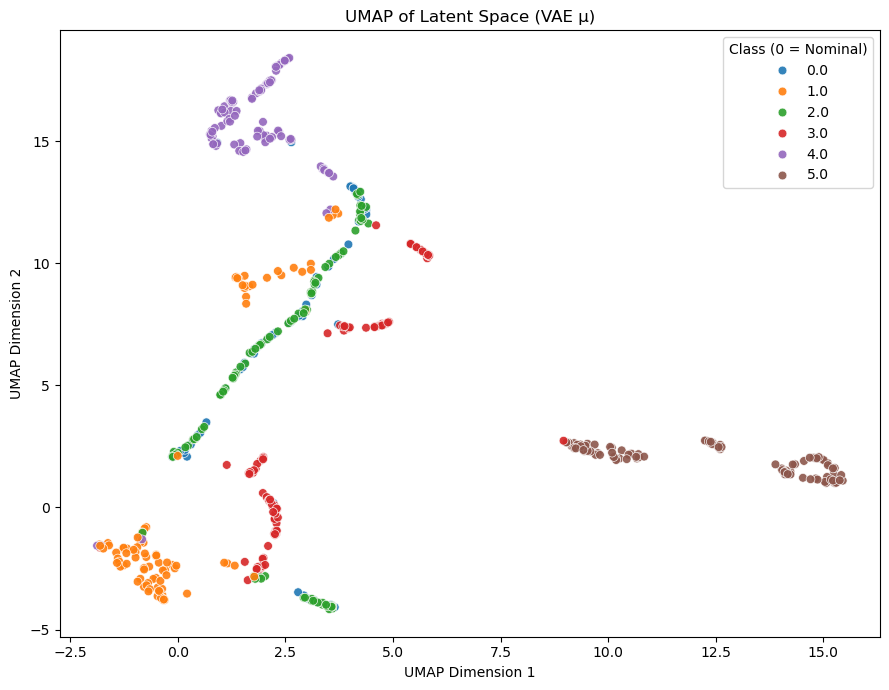

Saved: latent_tsne.png and latent_umap.png


In [26]:
"""
visualize_latent_space.py

Visualizations of latent μ vectors using:
    - t-SNE (2D)
    - UMAP  (2D)

Inputs:
    Z_train_nom.npy
    Z_train_fault.npy
    Z_test_nom.npy
    Z_test_fault.npy
    y_train_fault_sys.npy
    y_test_fault_sys.npy

Output:
    latent_tsne.png
    latent_umap.png
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.manifold import TSNE
import umap

# -----------------------------
# PATHS
# -----------------------------
PRE_DIR = Path(r"C:\Users\ahasa\project_root\data\eclss_preprocessed")

# Load latent vectors
Z_train_nom  = np.load(PRE_DIR / "Z_train_nom.npy")
Z_train_fault = np.load(PRE_DIR / "Z_train_fault.npy")
Z_test_nom  = np.load(PRE_DIR / "Z_test_nom.npy")
Z_test_fault = np.load(PRE_DIR / "Z_test_fault.npy")

# Load fault-type labels
y_train_fault = np.load(PRE_DIR / "y_train_fault_sys.npy")
y_test_fault  = np.load(PRE_DIR / "y_test_fault_sys.npy")

# Combine train + test
Z_nom   = np.vstack([Z_train_nom, Z_test_nom])
Z_fault = np.vstack([Z_train_fault, Z_test_fault])

y_fault = np.concatenate([y_train_fault, y_test_fault])
y_nom   = np.zeros(Z_nom.shape[0])  # nominal class 0

# Final combined set for visualization
Z_all = np.vstack([Z_nom, Z_fault])
y_all = np.concatenate([y_nom, y_fault])

print("Combined latent vectors shape:", Z_all.shape)

# =============================================================================
# t-SNE Visualization
# =============================================================================
print("Running t-SNE...")
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1500,
    metric="euclidean",
    random_state=42,
)

Z_tsne = tsne.fit_transform(Z_all)

plt.figure(figsize=(9, 7))
sns.scatterplot(
    x=Z_tsne[:, 0], y=Z_tsne[:, 1],
    hue=y_all,
    palette='tab10',
    s=40,
    alpha=0.9,
)
plt.title("t-SNE of Latent Space (VAE μ)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class (0 = Nominal)")
plt.tight_layout()
plt.savefig("latent_tsne.png", dpi=300)
plt.show()

# =============================================================================
# UMAP Visualization
# =============================================================================
print("Running UMAP...")
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

Z_umap = reducer.fit_transform(Z_all)

plt.figure(figsize=(9, 7))
sns.scatterplot(
    x=Z_umap[:, 0], y=Z_umap[:, 1],
    hue=y_all,
    palette='tab10',
    s=40,
    alpha=0.9,
)
plt.title("UMAP of Latent Space (VAE μ)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Class (0 = Nominal)")
plt.tight_layout()
plt.savefig("latent_umap.png", dpi=300)
plt.show()

print("Saved: latent_tsne.png and latent_umap.png")
